In [2]:
import os
import sys
import itertools
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
import matplotlib_venn
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertTokenizer, BertModel, BertForMaskedLM

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [4]:
DEVICE = 'cuda'

## load csvs

In [5]:
trn_df = pd.read_csv('../../mnt/inputs/origin/train.csv')
display(trn_df.shape, trn_df.head())
tst_df = pd.read_csv('../../mnt/inputs/origin/test.csv')
display(tst_df.shape, tst_df.head())
sub_df = pd.read_csv('../../mnt/inputs/origin/sample_submission.csv')
display(sub_df.shape, sub_df.head())

(6079, 41)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


(476, 11)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


(476, 31)

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


## basic eda

#### 文字の頭度合いを見てみる (trn, tst もそうだし、tokenizer 辞書ともそう)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [21]:
trn_words = list(itertools.chain.from_iterable(
    trn_df.question_title.apply(lambda x: x.split(' ')) +
    trn_df.question_body.apply(lambda x: x.split(' ')) +
    trn_df.answer.apply(lambda x: x.split(' '))
))


tst_words = list(itertools.chain.from_iterable(
    tst_df.question_title.apply(lambda x: x.split(' ')) +
    tst_df.question_body.apply(lambda x: x.split(' ')) +
    tst_df.answer.apply(lambda x: x.split(' '))
))

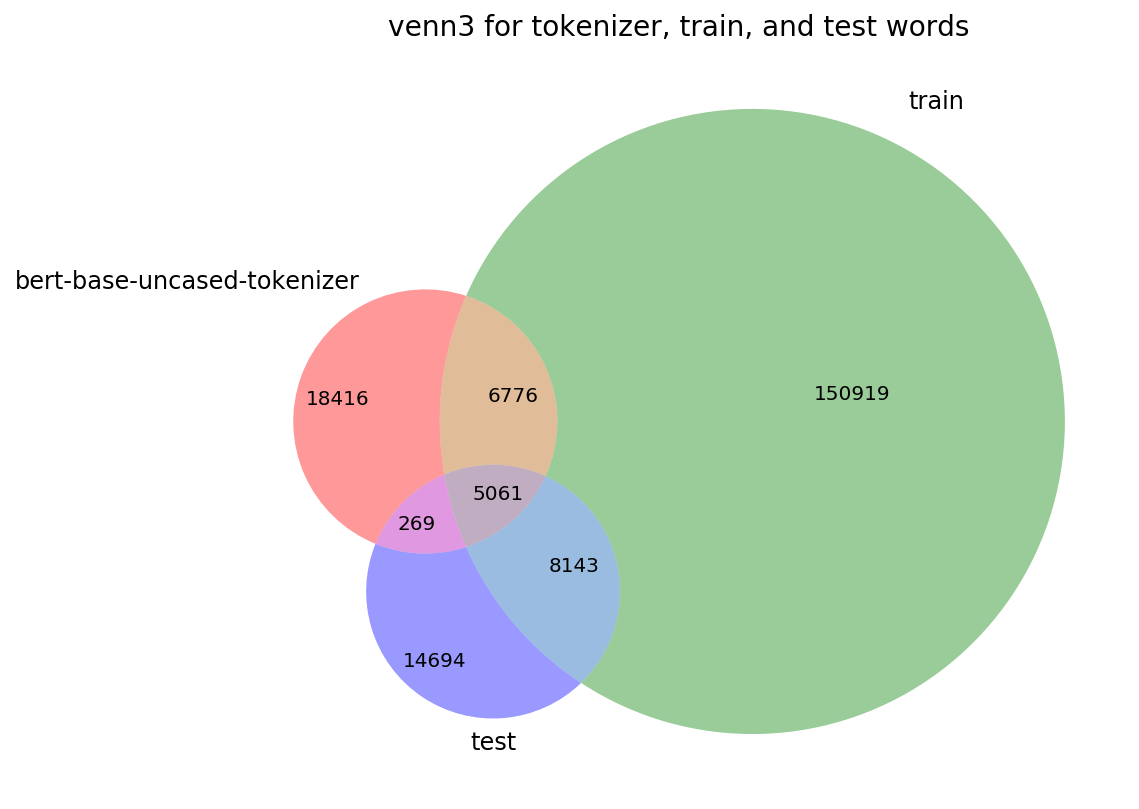

In [20]:
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(tokenizer.vocab), set(trn_words), set(tst_words)], set_labels=['bert-base-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words', fontsize=14)
plt.show()

## words を合わせてみたいが、どうやればよいか
 - train と test でかぶってない words もある... -> 最終的には train と test で共通の words のみ学習する or 全て pretrain する？
 - 表記ゆれとかで基本対策はできそう

#### 表記ゆれ対策でどう変わるか見てみる

In [63]:
trn_words_uncased = [word.lower() for word in trn_words]
tst_words_uncased = [word.lower() for word in tst_words]

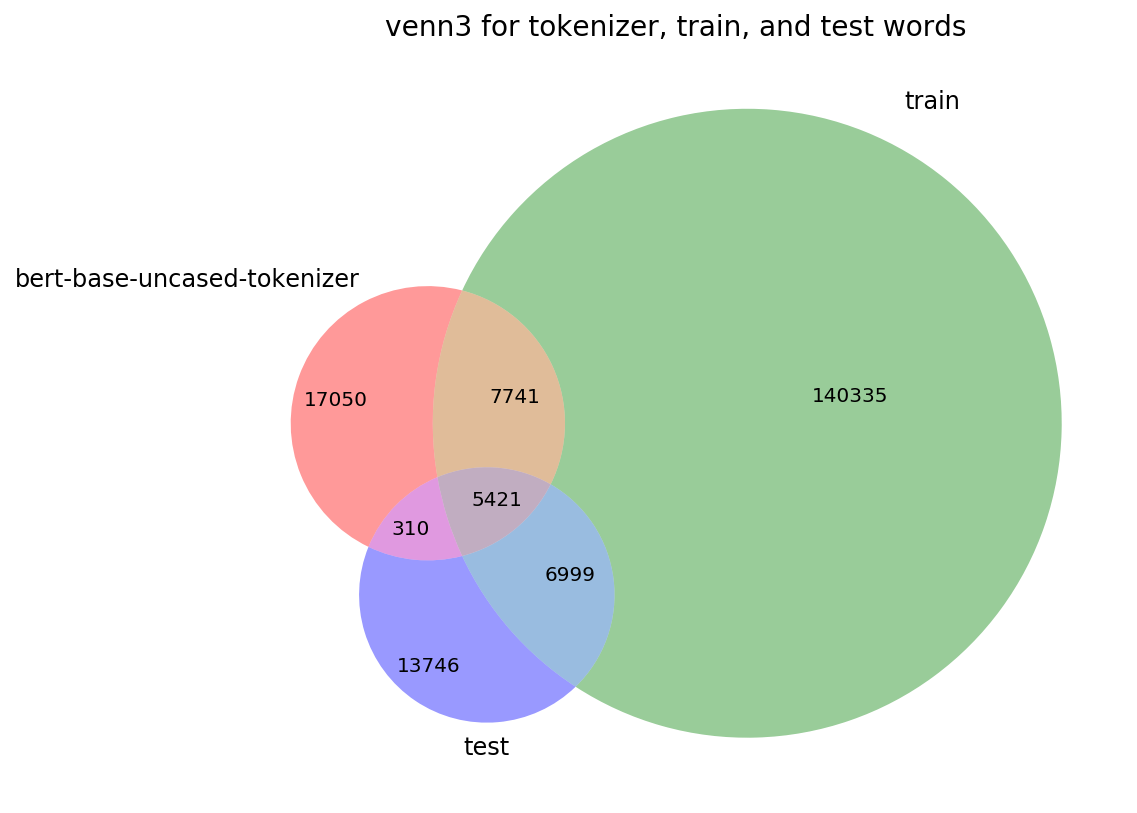

In [24]:
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(tokenizer.vocab), set(trn_words_uncased), set(tst_words_uncased)], set_labels=['bert-base-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words w/ lower', fontsize=14)
plt.show()

In [25]:
trn_words_uncased_2 = [word.casefold() for word in trn_words]
tst_words_uncased_2 = [word.casefold() for word in tst_words]

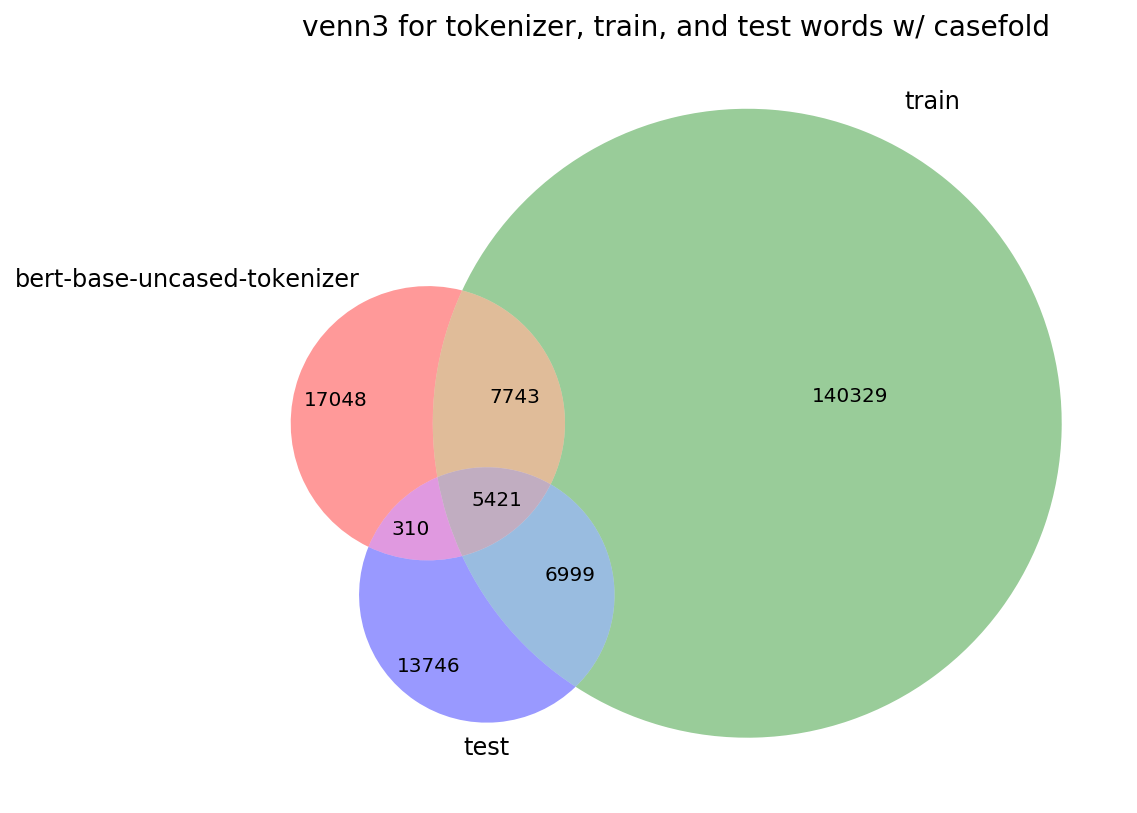

In [27]:
# これだとほぼ一緒
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(tokenizer.vocab), set(trn_words_uncased_2), set(tst_words_uncased_2)], set_labels=['bert-base-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words w/ casefold', fontsize=14)
plt.show()

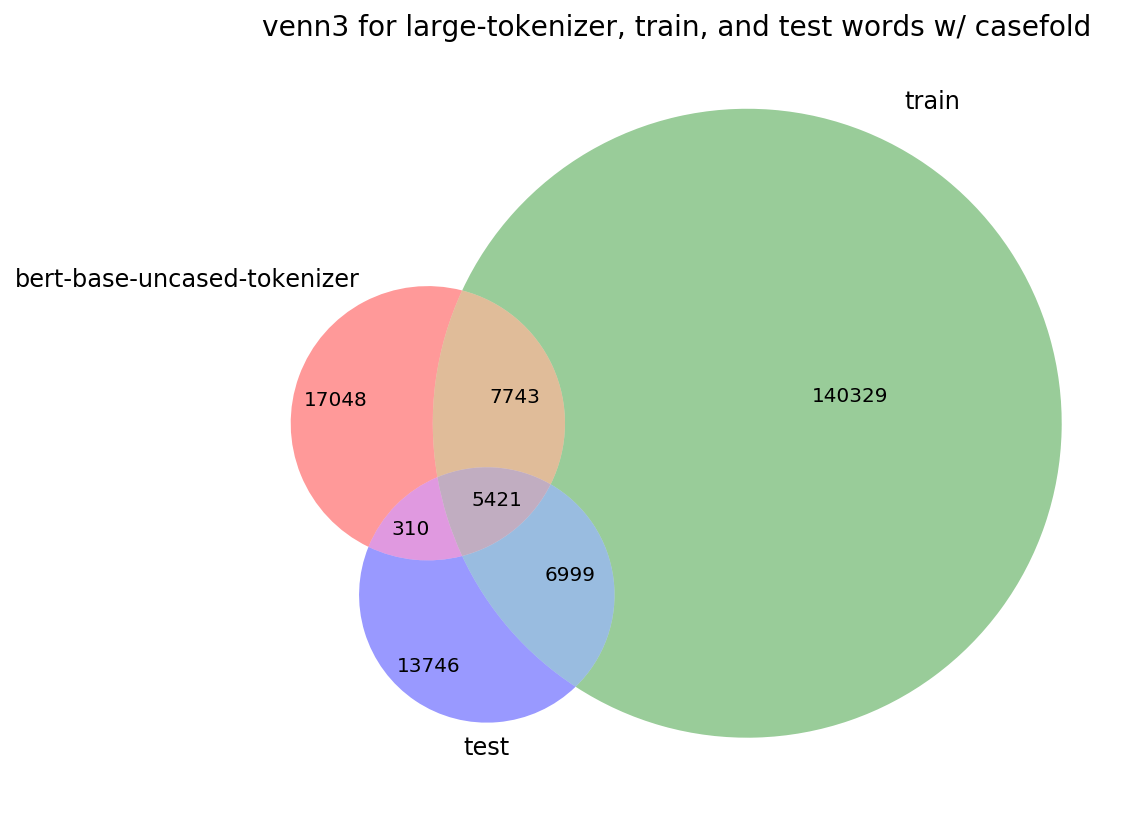

In [29]:
# ちなみに large だと...？
# かわらん
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(BertTokenizer.from_pretrained('bert-large-uncased').vocab), set(trn_words_uncased_2), set(tst_words_uncased_2)], set_labels=['bert-large-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words w/ casefold', fontsize=14)
plt.show()

In [34]:
(pd.Series(trn_words_uncased_2).value_counts() > 1).mean()

0.4148181840839419

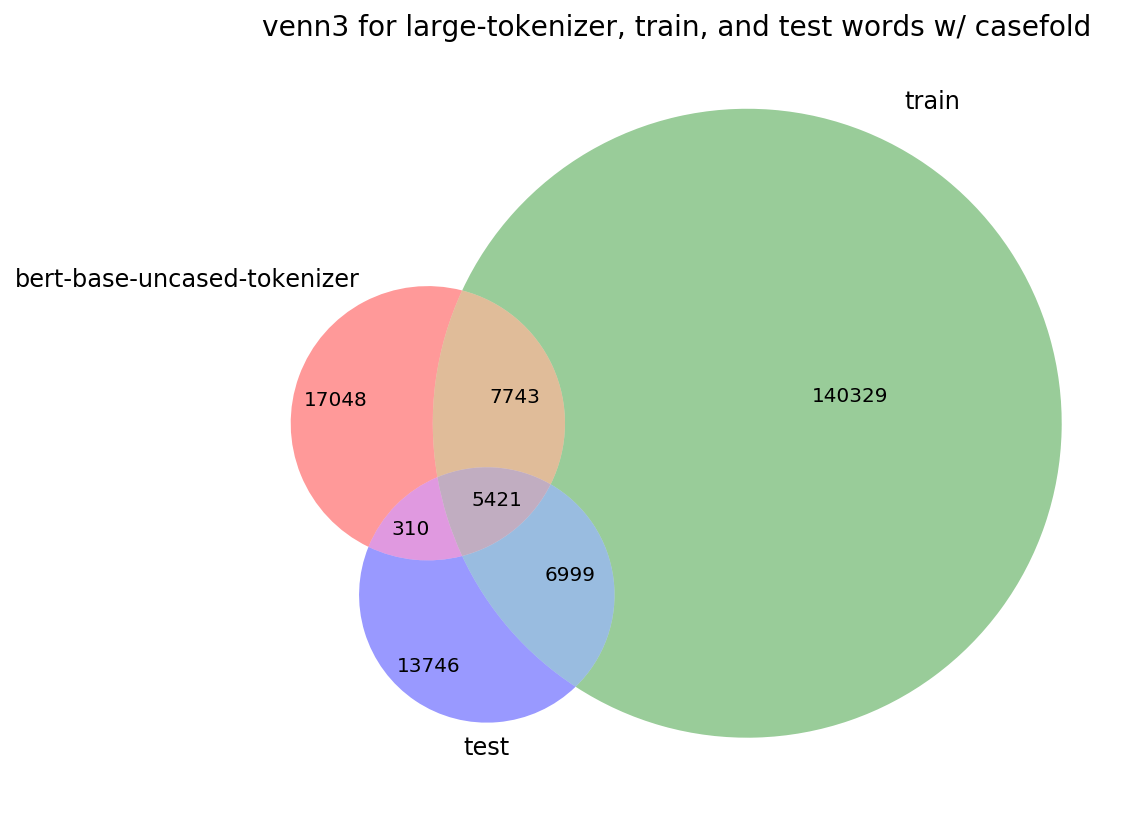

In [29]:
# 一回しか出てこないの除いてみる
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3(
    
    set_labels=['bert-large-uncased-tokenizer', 'train', 'test']
)
plt.title('venn3 for tokenizer, train, and test words w/ casefold', fontsize=14)
plt.show()

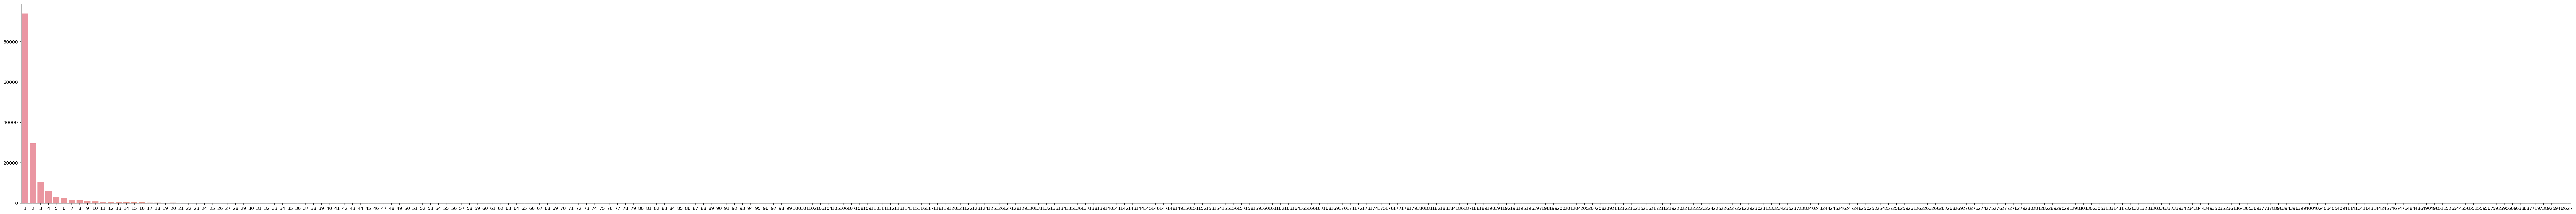

In [64]:
# words num hist
fig = plt.figure(figsize=(100, 8))

a = pd.Series(trn_words_uncased).value_counts().value_counts()
sns.barplot(a[a>1].index, a[a>1].values)

In [65]:
print(a[a.index>1].sum() / a.sum())
print(a[a.index>2].sum() / a.sum())
print(a[a.index>3].sum() / a.sum())
print(a[a.index>4].sum() / a.sum())
print(a[a.index>5].sum() / a.sum())
print(a[a.index>6].sum() / a.sum())

0.41480784567839696
0.22999950154520984
0.16406016349317118
0.125947064101286
0.10632663742398564
0.09065646495862825


In [51]:
tokenizer.add_tokens(['dasfasfasffasfdsfa', ])
print(tokenizer.encode('dasfasfasffasfdsfaaaa'))
tokenizer.decode(tokenizer.encode('dasfasfasffasfdsfaaaa'))

[101, 30524, 13360, 102]


'[CLS] dasfasfasffasfdsfa aaa [SEP]'

In [101]:
a = pd.Series(trn_words_uncased_preprocessed).value_counts()
(a >= 5).sum()

16212

In [102]:
set(a[a>=5].index) - set(tokenizer.vocab.keys())

{'',
 'o(log',
 '%s',
 'hour_in_seconds',
 'wget',
 '$v^\\bot$',
 'uid1',
 'link_to',
 'resubmit',
 'servername',
 'scheduler',
 'r2',
 'scrabble',
 'non-class',
 'd-mails',
 'physicists',
 'pmos',
 'done\ne',
 'impart',
 'gritty',
 'ui.chkboxlissage.ischecked',
 'has_one',
 'nserror',
 '^filesystem|shm|boot',
 'sel',
 '$\\ce{h2aso4-}$',
 '0xcd',
 'work-around',
 'serialportname',
 'egrep',
 'deletion',
 '2013-08-11',
 'iterating',
 '$query_args',
 '@array1',
 'slashes',
 '100%',
 'hello!&lt;br&gt',
 "id's",
 'dns',
 'charsequence',
 'fail2ban',
 'smartphones',
 'rdfa',
 'sonicwall',
 'vss',
 'motherboard',
 'idiomatic',
 'skywalker',
 'a.author.id',
 'seperate',
 'obfuscated',
 'foreground',
 'resetting',
 'sudo',
 '|\n|',
 'tenure-track',
 '2px',
 'polyploidy',
 '$value',
 'psk',
 'asynchronously',
 'deb',
 'are:\n\n\nneeding',
 '2.1',
 'barabbas',
 'burrs',
 'lag',
 'server.\n\nwhat',
 'np.float64(1)\n#s',
 'statistics?\n\none',
 'unicast',
 '7.\n*',
 'anycast',
 'sprawdz',
 'sandin

In [77]:
#%debug
tokenizer.add_tokens(a[a>=5].index.tolist())

> /opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py(2394)__nonzero__()
   2392             "The truth value of a {0} is ambiguous. "
   2393             "Use a.empty, a.bool(), a.item(), a.any() or a.all().".format(
-> 2394                 self.__class__.__name__
   2395             )
   2396         )

ipdb> q


0

In [79]:
list(tokenizer.vocab.keys())[-100:]

['##永',
 '##江',
 '##沢',
 '##河',
 '##治',
 '##法',
 '##海',
 '##清',
 '##漢',
 '##瀬',
 '##火',
 '##版',
 '##犬',
 '##王',
 '##生',
 '##田',
 '##男',
 '##疒',
 '##発',
 '##白',
 '##的',
 '##皇',
 '##目',
 '##相',
 '##省',
 '##真',
 '##石',
 '##示',
 '##社',
 '##神',
 '##福',
 '##禾',
 '##秀',
 '##秋',
 '##空',
 '##立',
 '##章',
 '##竹',
 '##糹',
 '##美',
 '##義',
 '##耳',
 '##良',
 '##艹',
 '##花',
 '##英',
 '##華',
 '##葉',
 '##藤',
 '##行',
 '##街',
 '##西',
 '##見',
 '##訁',
 '##語',
 '##谷',
 '##貝',
 '##貴',
 '##車',
 '##軍',
 '##辶',
 '##道',
 '##郎',
 '##郡',
 '##部',
 '##都',
 '##里',
 '##野',
 '##金',
 '##鈴',
 '##镇',
 '##長',
 '##門',
 '##間',
 '##阝',
 '##阿',
 '##陳',
 '##陽',
 '##雄',
 '##青',
 '##面',
 '##風',
 '##食',
 '##香',
 '##馬',
 '##高',
 '##龍',
 '##龸',
 '##ﬁ',
 '##ﬂ',
 '##！',
 '##（',
 '##）',
 '##，',
 '##－',
 '##．',
 '##／',
 '##：',
 '##？',
 '##～']

In [80]:
len(tokenizer.vocab.keys())

30522

In [99]:
trn_words_uncased_preprocessed = [word.casefold().strip().strip('()[]{}.,;:-?!\"\'\n') for word in trn_words]
tst_words_uncased_preprocessed = [word.casefold().strip().strip('()[]{}.,;:-?!\"\'\n') for word in tst_words]

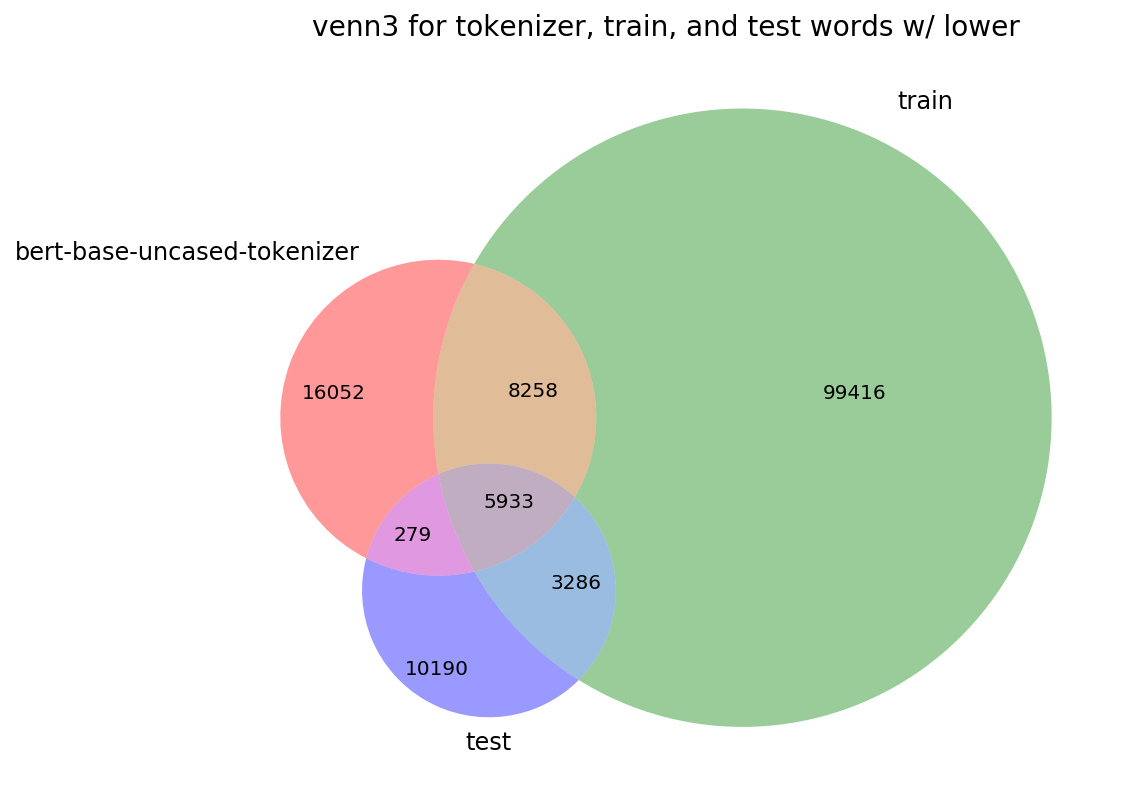

In [92]:
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(tokenizer.vocab), set(trn_words_uncased_preprocessed), set(tst_words_uncased_preprocessed)], set_labels=['bert-base-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words w/ lower', fontsize=14)
plt.show()

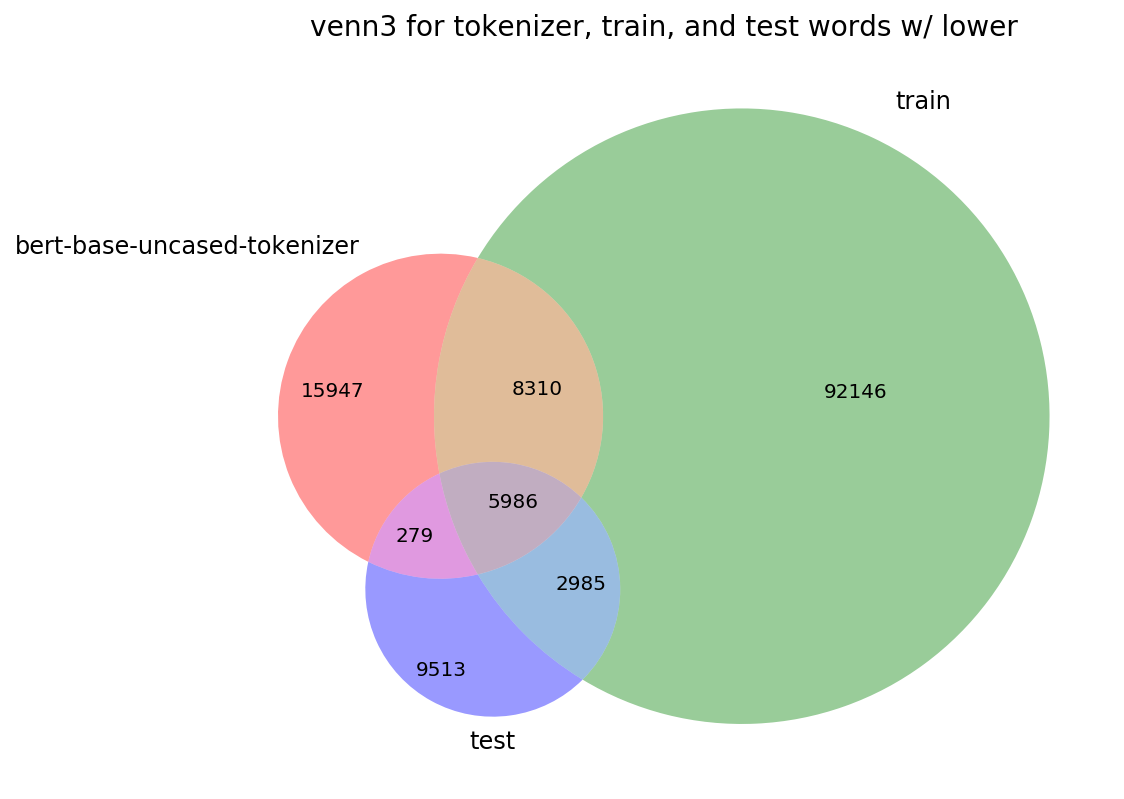

In [100]:
plt.figure(figsize=(8, 7))
matplotlib_venn.venn3([set(tokenizer.vocab), set(trn_words_uncased_preprocessed), set(tst_words_uncased_preprocessed)], set_labels=['bert-base-uncased-tokenizer', 'train', 'test'])
plt.title('venn3 for tokenizer, train, and test words w/ lower', fontsize=14)
plt.show()